# XOR with PyTorch — 성능 분석/시각화

## 개요
- XOR 문제를 간단한 MLP로 학습합니다.
- 에포크별 손실/정확도를 기록하고 최종 예측을 확인합니다.
- 2x2 그래프로 손실, 정확도, 결정 경계, 혼동 행렬을 시각화합니다.
- Matplotlib 한글 폰트를 자동 설정하여 글자 깨짐을 방지합니다.


In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

def _configure_korean_font():
    """Set a Korean-capable font for Matplotlib if available.

    Tries common fonts across Windows/macOS/Linux and ensures minus signs
    render correctly with Unicode fonts.
    """
    candidates = [
        'Malgun Gothic',  # Windows
        '맑은 고딕',        # Windows (Korean name)
        'AppleGothic',     # macOS
        'NanumGothic',     # Linux/macOS (often installed)
        'Noto Sans CJK KR', 'Noto Sans KR', 'Noto Sans CJK',
        'NanumBarunGothic', 'Gulim', 'Dotum', 'Batang',
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            rcParams['font.family'] = [name]
            rcParams['axes.unicode_minus'] = False
            return name
    rcParams['axes.unicode_minus'] = False
    return None

_configure_korean_font()


'Malgun Gothic'

In [2]:
# XOR dataset (2 inputs -> 1 output)
x_data = torch.tensor([[0., 0.],
                       [0., 1.],
                       [1., 0.],
                       [1., 1.]], dtype=torch.float32)
y_data = torch.tensor([[0.],
                       [1.],
                       [1.],
                       [0.]], dtype=torch.float32)


In [3]:
class XORNet(nn.Module):
    """Simple MLP with one hidden layer to solve XOR."""
    def __init__(self):
        super().__init__()
        # Two-layer perceptron: compress to hidden 2-D features, then predict XOR
        self.model = nn.Sequential(
            nn.Linear(2, 2),
            nn.Sigmoid(),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [4]:
# Train
model = XORNet()
criterion = nn.BCELoss()
# Binary cross entropy for probabilities and SGD for this tiny model
optimizer = optim.SGD(model.parameters(), lr=0.1)
losses = []
accuracies = []
start_time = time.perf_counter()

for epoch in range(10000):
    optimizer.zero_grad()            # 1) reset gradients from previous step
    outputs = model(x_data)          # 2) forward pass
    loss = criterion(outputs, y_data)  # 3) compute BCE loss
    loss.backward()                  # 4) backpropagate gradients
    optimizer.step()                 # 5) apply parameter update
    losses.append(loss.item())

    with torch.no_grad():
        epoch_preds = (model(x_data) > 0.5).float()
        epoch_acc = (epoch_preds.eq(y_data)).float().mean().item()
        accuracies.append(epoch_acc)

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch + 1:5d} | Loss: {loss.item():.6f} | Acc: {epoch_acc:.3f}')

with torch.no_grad():
    logits = model(x_data)
    preds = (logits > 0.5).float().squeeze()
    final_loss = criterion(logits, y_data).item()
    final_acc = (preds.eq(y_data.squeeze())).float().mean().item()
    print('Predictions:', preds.tolist())
    print(f'Final Loss: {final_loss:.6f} | Final Acc: {final_acc:.3f} ')


Epoch  1000 | Loss: 0.683674 | Acc: 0.750
Epoch  2000 | Loss: 0.605829 | Acc: 0.750
Epoch  3000 | Loss: 0.477341 | Acc: 0.750
Epoch  4000 | Loss: 0.232181 | Acc: 1.000
Epoch  5000 | Loss: 0.092845 | Acc: 1.000
Epoch  6000 | Loss: 0.052105 | Acc: 1.000
Epoch  7000 | Loss: 0.035283 | Acc: 1.000
Epoch  8000 | Loss: 0.026412 | Acc: 1.000
Epoch  9000 | Loss: 0.021006 | Acc: 1.000
Epoch 10000 | Loss: 0.017390 | Acc: 1.000
Predictions: [0.0, 1.0, 1.0, 0.0]
Final Loss: 0.017387 | Final Acc: 1.000 


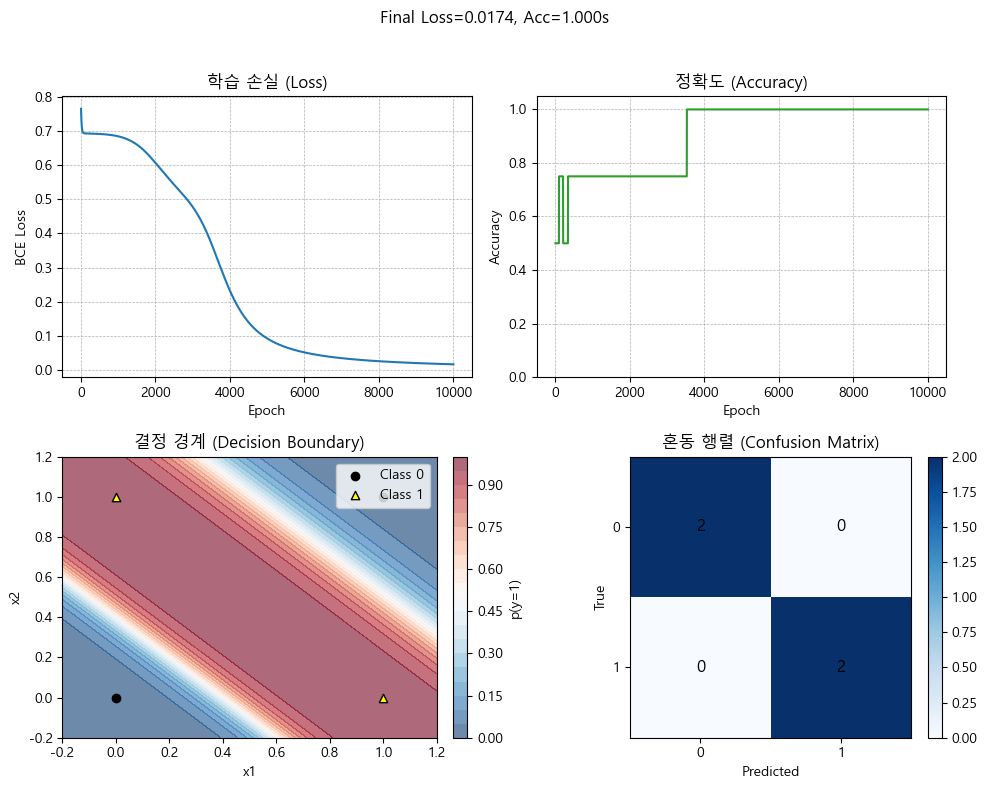

In [5]:
# Visualization (2x2)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1) Loss curve
ax = axes[0, 0]
ax.plot(range(1, len(losses) + 1), losses, color='tab:blue')
ax.set_title('학습 손실 (Loss)')
ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')
ax.grid(True, linestyle='--', linewidth=0.5)

# 2) Accuracy curve
ax = axes[0, 1]
ax.plot(range(1, len(accuracies) + 1), accuracies, color='tab:green')
ax.set_title('정확도 (Accuracy)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle='--', linewidth=0.5)

# 3) Decision boundary
ax = axes[1, 0]
with torch.no_grad():
    xv = torch.linspace(-0.2, 1.2, steps=200)
    yv = torch.linspace(-0.2, 1.2, steps=200)
    xx, yy = torch.meshgrid(xv, yv, indexing='ij')
    grid = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)
    # Evaluate model on dense grid to visualize non-linear separating surface
    zz = model(grid).reshape_as(xx).cpu().numpy()
cs = ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), zz, levels=20, cmap='RdBu_r', alpha=0.6)
x0 = x_data[y_data.squeeze() == 0]
x1 = x_data[y_data.squeeze() == 1]
ax.scatter(x0[:, 0], x0[:, 1], c='black', marker='o', label='Class 0')
ax.scatter(x1[:, 0], x1[:, 1], c='yellow', edgecolors='black', marker='^', label='Class 1')
ax.set_title('결정 경계 (Decision Boundary)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend(loc='upper right')
fig.colorbar(cs, ax=ax, fraction=0.046, pad=0.04, label='p(y=1)')

# 4) Confusion matrix
ax = axes[1, 1]
with torch.no_grad():
    y_true = y_data.squeeze().int()
    y_pred = preds.int()
    # Manual tally keeps dependencies light and clarifies what each cell means
    tp = int(((y_true == 1) & (y_pred == 1)).sum().item())
    tn = int(((y_true == 0) & (y_pred == 0)).sum().item())
    fp = int(((y_true == 0) & (y_pred == 1)).sum().item())
    fn = int(((y_true == 1) & (y_pred == 0)).sum().item())
cm = np.array([[tn, fp], [fn, tp]], dtype=int)
im = ax.imshow(cm, cmap='Blues')
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', color='black', fontsize=12)
ax.set_title('혼동 행렬 (Confusion Matrix)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle(f'Final Loss={final_loss:.4f}, Acc={final_acc:.3f}s', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
